# EfficientNet'te Transfer Öğrenmenin Etkisi
---
[Ölçeklendirme ile CNN Modelinin Doğruluk ve Verimliliğini Artırma: EfficientNet]() blog yazısının eki olarak hazırlanmış uygulamada [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) veri kümesi üzerinde EfficientNet içi Transfer Öğrenme gerçekleştirilmiştir.

---

### Kaynaklar: 

*   [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/pdf/1905.11946v3.pdf)

*   [Implementation of EfficientNet model. Keras and TensorFlow Keras](https://github.com/qubvel/efficientnet)
*   [Papers with Codes](https://paperswithcode.com/paper/efficientnet-rethinking-model-scaling-for)
*   [EfficientNet: Improving Accuracy and Efficiency through AutoML and Model Scaling](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html)
*   [How to do Transfer learning with Efficientnet](https://www.dlology.com/blog/transfer-learning-with-efficientnet/)
*   [Training EfficientNets on TPUs](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet)








**Google Colab Kimlik Doğrulama Aşaması**

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


**EfficientNet Kaynak Kodunun Yüklenmesi**

In [0]:
import warnings
warnings.filterwarnings("ignore")

!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-g5u1k6ri
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-g5u1k6ri
  Created wheel for efficientnet: filename=efficientnet-1.0.0-cp36-none-any.whl size=17686 sha256=9d0d62deadd1272ba48f639789efa44741fa73c49ed45362d41444f4cb46a70c
  Stored in directory: /tmp/pip-ephem-wheel-cache-y8gz5bik/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet


**Gerekli Kütüphanelerin Yüklenmesi** 

In [0]:
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
import efficientnet.keras as enet

Using TensorFlow backend.


**CIFAR10 Veri Kümesinin Yüklenmesi**

In [0]:
# CIFAR10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Sınıf vektörlerini ikili sınıf matrislerine dönüştürme
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

170500096/170498071 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


**Swish Aktivasyon Fonksiyonun Tanımlanması**

---

Swish ile ilgili [buradan](https://medium.com/@ayyucekizrak/derin-%C3%B6%C4%9Frenme-i%C3%A7in-aktivasyon-fonksiyonlar%C4%B1n%C4%B1n-kar%C5%9F%C4%B1la%C5%9Ft%C4%B1r%C4%B1lmas%C4%B1-cee17fd1d9cd) daha detaylı bilgiye ulaşabilirsiniz!

In [0]:
from keras.backend import sigmoid

class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers impokolart Activation
get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

**EfficientNet-B0'ın yüklemesi** (önceden ImageNet'te eğitilmiştir.)

In [0]:
model = enet.EfficientNetB0(include_top=False, input_shape=(32,32,3), pooling='avg', weights='imagenet')

# 2 tam bağlantı katmanının B0'a eklenmesi
x = model.output

x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)

# Çıkış katmanı
predictions = Dense(10, activation="softmax")(x)

model_final = Model(inputs = model.input, outputs = predictions)

model_final.summary()











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
16809984/16804768 [==============================] - 1s 0us/step

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 16, 16, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 16, 16, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________


In [13]:
!pwd

/gdrive


**Modelin Derlenmesi ve En iyi Sonuçların Kaydedilmesi**

In [19]:
model_final.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy'])

mcp_save = ModelCheckpoint('/gdrive/My Drive/EnetB0_CIFAR10_TL.h5', save_best_only=True, monitor='val_acc')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1,)

#print("Training....")
model_final.fit(x_train, y_train,
              batch_size=32,
              epochs=10,
              validation_split=0.1,
              callbacks=[mcp_save, reduce_lr],
              shuffle=True,
              verbose=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 178s 4ms/step - loss: 0.6078 - acc: 0.7971 - val_loss: 0.5557 - val_acc: 0.8186
Epoch 2/10
45000/45000 [==============================] - 147s 3ms/step - loss: 0.5454 - acc: 0.8156 - val_loss: 0.5343 - val_acc: 0.8220
Epoch 3/10
45000/45000 [==============================] - 146s 3ms/step - loss: 0.5012 - acc: 0.8334 - val_loss: 0.5257 - val_acc: 0.8300
Epoch 4/10
45000/45000 [==============================] - 147s 3ms/step - loss: 0.4570 - acc: 0.8468 - val_loss: 0.5119 - val_acc: 0.8248
Epoch 5/10
45000/45000 [==============================] - 146s 3ms/step - loss: 0.4123 - acc: 0.8616 - val_loss: 0.5077 - val_acc: 0.8262

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 6/10
45000/45000 [==============================] - 147s 3ms/step - loss: 0.3567 - acc: 0.8803 - val_loss: 0.4945 - val_acc: 0.8320
Epoch 7/10
45000/45000 [==================

In [20]:
_, acc = model_final.evaluate(x_test, y_test)

10000/10000 [==============================] - 5s 474us/step


**Test Başarımının Ekrana Yazdırılması**

In [21]:
print("Test Accuracy: {}%".format(acc*100))

Test Accuracy: 82.78999999999999%


**Confusion Matrisin Oluşturulması ve Görselleştirmesi**

In [0]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

test_pred = model_final.predict(x_test)

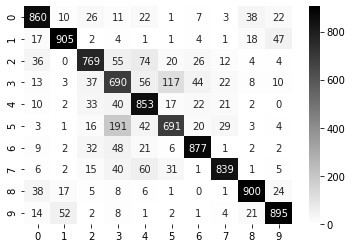

In [28]:
import numpy as np

ax = sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1),np.argmax(test_pred, axis=1)), cmap="binary",annot=True,fmt="d")

**MBCovn** Bloğu

In [0]:
def mbConv_block(input_data, block_arg):
    """Mobile Inverted Residual block along with Squeeze and Excitation block."""
    kernel_size = block_arg.kernel_size
    num_repeat= block_arg.num_repeat
    input_filters= block_arg.input_filters
    output_filters= output_filters.kernel_size
    expand_ratio= block_arg.expand_ratio
    id_skip= block_arg.id_skip
    strides= block_arg.strides
    se_ratio= block_arg.se_ratio
    # Genişleme Evresi
    expanded_filters =  input_filters * expand_ratio
    x = Conv2D(expanded_filters, 1,  padding='same',  use_bias=False)(input_data)
    x = BatchNormalization()(x)
    x = Activation(swish_activation)(x)
    # Depthwise Evrişim Evresi
    x = DepthwiseConv2D(kernel_size, strides,  padding='same',  use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation(swish_activation)(x)
    # Sıkıştırma ve Çıkarma Evresi
    se = GlobalAveragePooling2D()(x)
    se = Reshape((1, 1, expanded_filters ))(x)
    squeezed_filters = max (1, int(input_filters * se_ratio))
    se = Conv2D(squeezed_filters , 1, activation=swish_activation, padding='same')(se)
    se = Conv2D(expanded_filters, 1, activation='sigmoid', padding='same')(se)
    x = multiply([x, se])
    # Çıkış 
    x = Conv2D(output_filters, 1, padding='same', use_bias=False)
    x = BatchNormalization()(x)
    return x
